### Notebook to genereate mean vertical profiles from TC output

Assumes output is in a single netcdf file on pressure levels.

James Ruppert  
jruppert@ou.edu  
4/23/22

In [1]:
from netCDF4 import Dataset
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sys
from misc_functions import density_moist, theta_dry, relh
from stratiform_index import stratiform_index

#### Variable selection

In [2]:
# Fill variable
fillvar_select = 'tprm'
# options: lwcrf, tprm, dbz, rh

#### Time selection

In [3]:
nt=48
t0 = 48
t1 = t0+nt

#### Directories

In [4]:
figdir = "/Users/jruppert/code/tc_figs/"

# main = "/Users/jamesruppert/code/tc_output/"
main = "/Users/jruppert/code/tc_output/"
storm = !ls $main
# print(storm)

istorm=storm[0]
memb = !ls $main/$istorm
imemb=memb[0]
# print(main+istorm+'/'+imemb)

datdir = main+istorm+'/'+imemb+'/ctl/'
print(datdir)

/Users/jruppert/code/tc_output/haiyan/memb_01/ctl/


#### Read variables

In [5]:
# Fill contour variable

# Vertical coordinate
filtmp = Dataset(datdir+'RTHRATLW.nc')
pres = filtmp.variables['pres'][:] # hPa
print("Vertical shape: ",np.shape(pres))
filtmp.close()

# Radar Reflectivity
if fillvar_select == 'dbz':
    varfil_main = Dataset(datdir+'dbz.nc') # this opens the netcdf file
    binvar_f_in = varfil_main.variables['dbz'][t0:t1,:,:,:]
    title = 'Ref'
    units_var1 = 'dBZ'
    cmin = -20; cmax=20

# Radiation
elif fillvar_select == 'lwcrf':
    varfil_main = Dataset(datdir+'RTHRATLW.nc') # this opens the netcdf file
    binvar_f_in = varfil_main.variables['RTHRATLW'][t0:t1,:,:,:] * 3600.*24 # K/s --> K/d
    varcs = Dataset(datdir+'RTHRATLWC.nc') # this opens the netcdf file
    cs = varcs.variables['RTHRATLWC'][t0:t1,:,:,:] * 3600.*24 # K/s --> K/d
    binvar_f_in -= cs
    title = 'Binned LW-CRF'
    figtag = 'lwcrf'
    units_var1 = 'K/d'
    cmax=4; cmin=-1.*cmax

# Horizontal temperature anomaly
elif fillvar_select == 'tprm':
    varfil_main = Dataset(datdir+'T.nc')
    tmp = varfil_main.variables['T'][t0:t1,:,:,:] # K
    binvar_f_in = theta_dry(tmp,(pres[np.newaxis,:,np.newaxis,np.newaxis])*1e2) # K
    title = "Binned Th'"
    figtag = 'thprm'
    units_var1 = 'K'
    cmax=1; cmin=-1.*cmax
    # Subtract time-dependent domain average
    t_mean = np.mean(np.mean(binvar_f_in,axis=3),axis=2)
    binvar_f_in -= t_mean[:,:,np.newaxis,np.newaxis]

# Relative humidity
elif fillvar_select == 'rh':
    varfil_main = Dataset(datdir+'QVAPOR.nc')
    qv = varfil_main.variables['QVAPOR'][t0:t1,:,:,:] # kg/kg
    varfil_main.close()
    varfil_main = Dataset(datdir+'T.nc')
    tmpk = varfil_main.variables['T'][t0:t1,:,:,:] # K
    binvar_f_in = relh(qv,(pres[np.newaxis,:,np.newaxis,np.newaxis])*1e2,tmpk,ice=1) # RH in %
    title = "Binned RH"
    figtag = 'rh'
    units_var1 = '%'
    cmax=100; cmin=20

varfil_main.close()
tmpfil = Dataset(datdir+'T.nc')
tmpk = tmpfil.variables['T'][t0:t1,:,:,:] # K
tmpfil.close()

Vertical shape:  (10,)


In [6]:
# Two-dimensional variables

# Conv/strat separation: varout = 1 if convective, = 2 if stratiform, = 3 other, = 0 if no rain
varfil_strat = Dataset(datdir+'strat.nc') # this opens the netcdf file
strat = varfil_strat.variables['strat'][t0:t1,:,:,:]
varfil_strat.close()

# LW-ACRE
binfil = Dataset(datdir+'LWacre.nc') # this opens the netcdf file
lwacre = binfil.variables['LWUPB'][t0:t1,:,:,:] # W/m2
binfil.close()

# Rainfall
binfil = Dataset(datdir+'rainrate.nc') # this opens the netcdf file
rain = binfil.variables['rainrate'][t0:t1,:,:,:] # mm/hr
binfil.close()

# For density
# fil = Dataset(datdir+'T.nc')
# tmpk = fil.variables['T'][t0:t1,:,:,:] # K
# fil.close()
# fil = Dataset(datdir+'QVAPOR.nc')
# qv = fil.variables['QVAPOR'][t0:t1,:,:,:] # kg/kg
# fil.close()

bv_shape = np.shape(binvar_f_in)
print("Binvar shape: ",bv_shape)
nt = bv_shape[0]
nz = bv_shape[1]
nx1 = bv_shape[2]
nx2 = bv_shape[3]

Binvar shape:  (48, 10, 740, 1400)


In [7]:
# Line contour variable

# Vertical motion
varfil_cvar = Dataset(datdir+'W.nc') # this opens the netcdf file
w = varfil_cvar.variables['W'][t0:t1,:,:,:] # m/s
varfil_cvar.close()
binvar_c_in = w*1e2 # m/s --> cm/s
units_var2='cm/s'
lcmin = -20; lcmax=20; lcint=2

#### Calculate VMF

In [27]:
# Vmf in lower and upper trop
dp = 10000. # Pa
g = 9.81 # m/s2
ktop1=500
ktop2=100
iktop1 = np.where(pres == ktop1)[0][0]
iktop2 = np.where(pres == ktop2)[0][0]
print(pres)
# Layer VMF = -1/g SUM(w * dp) = m/s * s**2/m * kg/m/s**2 = kg/s/m
vmf_lower = np.mean(w[:,0:iktop1,:,:],1) * dp/g
vmf_upper = np.mean(w[:,iktop1:iktop2,:,:],1) * dp/g
vmf_lower = np.reshape(vmf_lower,(nt,1,nx1,nx2))
vmf_upper = np.reshape(vmf_upper,(nt,1,nx1,nx2))
vmf = vmf_lower + vmf_upper
vmf_th = (vmf_upper - vmf_lower) / vmf

[1000.  900.  800.  700.  600.  500.  400.  300.  200.  100.]


#### New conv/strat index

In [9]:
strat2 = stratiform_index(rain,vmf_lower,vmf_upper,verbose=0)

#### Average for Conv, Strat, and Anvil

In [28]:
indices_s = (strat == 2).nonzero()
indices_c = (strat == 1).nonzero()

vmf_up_s = np.mean(vmf_upper[indices_s],dtype=np.float64)
print(vmf_up_s)
vmf_up_c = np.mean(vmf_upper[indices_c],dtype=np.float64)
print(vmf_up_c)
vmf_th_s = np.mean(vmf_th[indices_s],dtype=np.float64)
print(vmf_th_s)
vmf_th_c = np.mean(vmf_th[indices_c],dtype=np.float64)
print(vmf_th_c)

w_s=np.zeros(nz)
w_c=np.zeros(nz)

for iz in range(nz):
    w_s[iz] = np.mean(w[indices_s[0],iz,indices_s[2],indices_s[3]],dtype=np.float64)
    w_c[iz] = np.mean(w[indices_c[0],iz,indices_c[2],indices_c[3]],dtype=np.float64)


83.55503160795217
1072.1226613374217
1.188772354752747
-0.616101266144855


---
### Plotting routines

In [11]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

### Plot profiles

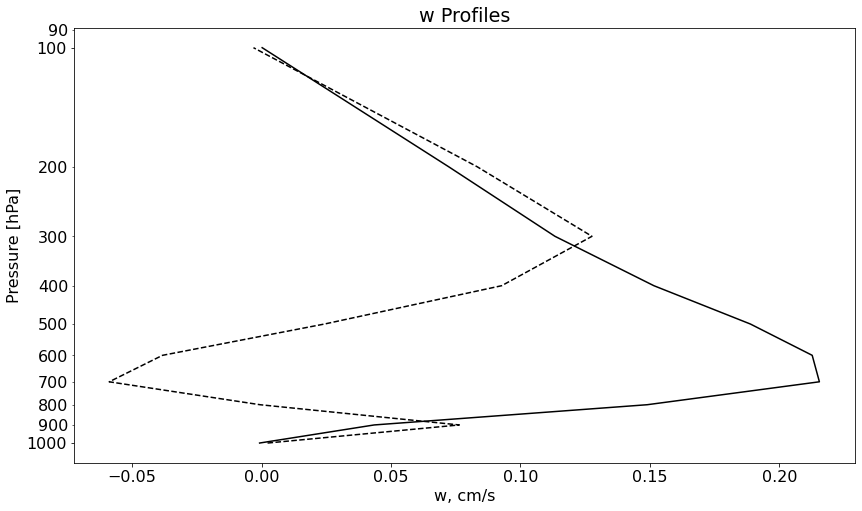

In [22]:
# create figure
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(111)

ax.set_title('w Profiles')
ax.set_ylabel('Pressure [hPa]')

plt.plot(w_c/8, pres, "-k", label="Convective")
plt.plot(w_s, pres, "--k", label="Stratiform")

ax.invert_yaxis()
ax.set_yscale('log')

ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.yaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())

ax.set_xlabel('w, '+units_var2)
# plt.xlim(np.min(bins), np.max(bins))

plt.show()
# plt.savefig(figdir+figtag+'_compcross_'+imemb+'_'+ivar_select+'.png',dpi=200, facecolor='white', \
#             bbox_inches='tight', pad_inches=0.2)